

<h3 style="text-align:center; background-color:#C8FF33;padding:40px;border-radius: 30px;">
<p style="text-align: left">See also this notebook:</p>
    <p style="text-align: left"><b><a href="https://www.kaggle.com/code/soumya9977/hubmap-multiorgan-segmentation-1-3-data-prep"> &nbsp; HuBMAP multiOrgan Segmentation 1/3 [data prep]</a></b></p>
    <p style="text-align: left"><b>* HuBMAP: Vanilla Unet + W&B + Pytorch 2/3 [train]</b></p>
    <p style="text-align: left"><b><a href="https://www.kaggle.com/code/soumya9977/hubmap-vanilla-unet-pytorch-3-3-inference"> &nbsp; HuBMAP: Vanilla Unet Pytorch 3/3 [inference]</a></b></p>
</h3>


## Please _DO_ upvote!


### Changelog

|| Version | Comments | LB |
|---|  --- | --- | --- |
|**Best**| -- | effNetUnet w/ 256x256, 50 epoch, no aug, Warmup CosineAnnealingLR lr sch, no pre/post processing, L2 norm, bs=8 | `--` |

In [10]:
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [11]:
# !pip install -q tifffile

In [12]:
!nvidia-smi

Sun Aug 14 00:10:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 28%   39C    P8    33W / 250W |    542MiB / 11016MiB |     32%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Import, SEED, Config:

In [13]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import warnings
import cv2
import matplotlib.pyplot as plt
import json
import gc
import time
from tqdm import tqdm
import random
from collections import defaultdict
from IPython.display import display

#Pytorch Imports
import torch
import torchvision # torch package for vision related things
import torch.nn.functional as F  # Parameterless functions, like (some) activation functions
import torchvision.datasets as datasets  # Standard datasets
import torchvision.transforms as transforms  # Transformations we can perform on our dataset for augmentation
from torch import optim  # For optimizers like SGD, Adam, etc.
from torch import nn  # All neural network modules
from torch.utils.data import Dataset, DataLoader  # Gives easier dataset managment by creating mini batches etc.
from tqdm import tqdm  # For nice progress bar!
from torchvision.transforms import Resize
from torchaudio.transforms import MelSpectrogram, AmplitudeToDB
from torch.optim import lr_scheduler
# from tifffile import imread
import segmentation_models_pytorch as smp
# import transformers
from sklearn.model_selection import StratifiedKFold, KFold, StratifiedGroupKFold

from albumentations.pytorch.transforms import ToTensorV2
import albumentations as A
from sklearn.model_selection import train_test_split

# For colored terminal text
from colorama import Fore, Back, Style
c_ = Fore.CYAN
sr_ = Style.RESET_ALL
b_ = Fore.BLUE

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

warnings.filterwarnings("ignore")

In [14]:
# Hyperparameters etc.
# Hyperparameters
CONFIG = {
    "in_channels" :3,
    "num_classes": 1,
    "BATCH_SIZE" : 8,
    "NUM_EPOCHS" : 100,
    "n_accumulate": 1,
    "competition": "HuBMAP-Kaggle", # HuBMAP-Kaggle
    "model_name": "Vanilla_Unet",
    "LEARNING_RATE": 1e-4,
    "DEVICE": "cuda" if torch.cuda.is_available() else "cpu", 
    "AUG": "No",
    "SEED": 2022,
    "opt": 'Adam',
    "Normalization": "L2",
    "img_size": 256,
    "scheduler": "",#'CosineAnnealingLR',
    "warmup_epochs": 2,
    "n_folds": 5,
    "folds_to_run": [0],
    "min_lr": 1e-6,
    "T_max": 500, 
    "T_0": 20
}

In [15]:
def set_seed(seed = 42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    print('> SEEDING DONE')
    
set_seed(CONFIG["SEED"])

> SEEDING DONE


# WandB:

In [16]:
# import wandb

# # try:
# #     from kaggle_secrets import UserSecretsClient
# #     user_secrets = UserSecretsClient()
# #     api_key = user_secrets.get_secret("WANDB")
# #     wandb.login(key=api_key)
# #     anonymous = None
# # except:
# #     anonymous = "must"
# #     print('To use your W&B account,\nGo to Add-ons -> Secrets and provide your W&B access token. Use the Label name as WANDB. \nGet your W&B access token from here: https://wandb.ai/authorize')
# # wandb.init(project="PogChamp2 Baseline")
# run = wandb.init(project=CONFIG['competition'], 
#                  config=CONFIG,
#                  job_type='Train',
#                  tags=['semantic segmentation', CONFIG['model_name']],
#                  anonymous='must',
#                  name = "Vanilla_Unet_1",
#                  notes = "")

## Tabular:

In [17]:
pd.read_csv("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/hubmap-organ-segmentation/train.csv")["organ"].value_counts()

kidney            99
prostate          93
largeintestine    58
spleen            53
lung              48
Name: organ, dtype: int64

In [18]:
# !ls ../input/hubmap-tiled-data-generation/tiled_data
DATA_DIR = "/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/"

img_list = [os.path.join(DATA_DIR+'images',i) for i in os.listdir(DATA_DIR+"images")]
mask_list = [os.path.join(DATA_DIR+'binary_masks',i) for i in os.listdir(DATA_DIR+"binary_masks")]

data_dict = {
    "img_path": img_list,
    "mask_path": mask_list
}

train_df = pd.DataFrame.from_dict(data_dict)
pd.set_option('display.max_colwidth', None)
display(train_df)
# plt.imshow(plt.imread(mask_list[3]))
# img_list[0:5],mask_list[0:5]

,img_path,mask_path
0,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/8388_04.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/8388_04.png
1,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/9450_04.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/9450_04.png
2,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/1500_03.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/1500_03.png
3,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/23961_06.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/23961_06.png
4,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/21086_00.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/21086_00.png
...,...,...
3154,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/6611_05.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/6611_05.png
3155,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/24961_00.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/24961_00.png
3156,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/351_03.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/351_03.png
3157,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/1229_04.png,/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/1229_04.png


In [19]:
train_df["img_path"].iloc[0], train_df["mask_path"].iloc[0]

('/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/8388_04.png',
 '/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/binary_masks/8388_04.png')

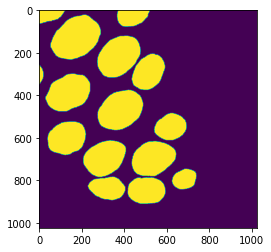

In [20]:
mask_cee = plt.imread(train_df["mask_path"].iloc[9]).astype(np.float16)
a = mask_cee
new_a = np.where(a > 0, 1, a)
plt.imshow(new_a)

[0.13333334 0.13725491 0.14509805 0.14901961 0.15294118 0.16078432
 0.16470589 0.16862746 0.17254902 0.1764706  0.18039216 0.18431373
 0.1882353  0.19215687 0.19607843 0.2        0.20392157 0.20784314
 0.21176471 0.21568628 0.21960784 0.22352941 0.22745098 0.23137255
 0.23529412 0.23921569 0.24313726 0.24705882 0.2509804  0.25490198
 0.25882354 0.2627451  0.26666668 0.27058825 0.27450982 0.2784314
 0.28235295 0.28627452 0.2901961  0.29411766 0.29803923 0.3019608
 0.30588236 0.30980393 0.3137255  0.31764707 0.32156864 0.3254902
 0.32941177 0.33333334 0.3372549  0.34117648 0.34509805 0.34901962
 0.3529412  0.35686275 0.36078432 0.3647059  0.36862746 0.37254903
 0.3764706  0.38039216 0.38431373 0.3882353  0.39215687 0.39607844
 0.4        0.40392157 0.40784314 0.4117647  0.41568628 0.41960785
 0.42352942 0.42745098 0.43137255 0.43529412 0.4392157  0.44313726
 0.44705883 0.4509804  0.45490196 0.45882353 0.4627451  0.46666667
 0.47058824 0.4745098  0.47843137 0.48235294 0.4862745  0.4901960

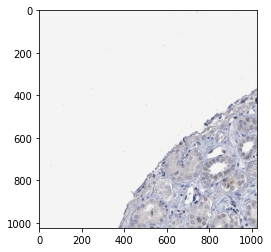

In [21]:

img_cee = plt.imread("/home/lakshita/somusan/hubmap_kaggle/hubmap_data/tiled_data/images/62_00.png")
plt.imshow(img_cee)
print(np.unique(img_cee))

In [22]:
train_df, test_df = train_test_split(train_df, test_size=0.2, random_state=CONFIG["SEED"])
train_df.__len__(), len(test_df)

(2527, 632)

In [23]:
# %timeit img_temp = plt.imread(train_df["mask_path"].iloc[0])

# Pytorch Data Class:

In [24]:
mean = np.array([0, 0.74582646, 0.74582646])
std = np.array([0.24745085, 0.26182273, 0.25782376])
a = mean
new_a = np.where(a == 0.74582646, 1, a)
new_a
# torch.from_numpy(mean).to(torch.uint8)


array([0., 1., 1.])

In [25]:
mean = np.array([0.7720342, 0.74582646, 0.76392896])
std = np.array([0.24745085, 0.26182273, 0.25782376])


def img2tensor(img,dtype:np.dtype=np.float32):
    if img.ndim==2 : img = np.expand_dims(img,2)
    img = np.transpose(img,(2,0,1))
    return torch.from_numpy(img.astype(dtype, copy=False))



class hubmap_data(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.img_paths = df["img_path"].to_numpy()
        self.mask_paths = df["mask_path"].to_numpy()
        self.transform = transform
        
        
    def __getitem__(self, index):
        # load data from the pre-processed npy files
        img_file = self.img_paths[index]

        mask_file = self.mask_paths[index]
        
        img = cv2.cvtColor(cv2.imread(img_file), cv2.COLOR_BGR2RGB)
        mask = cv2.imread((mask_file),cv2.IMREAD_GRAYSCALE)
        if self.transform is not None:
            transformed = self.transform(image=img, mask=mask)
            img = transformed["image"]
            mask = transformed["mask"]
            mask=mask.reshape((1, mask.shape[0], mask.shape[1]))

            if mask.shape[-1] == 1:
                mask = mask.permute(2,0,1)
                

        return  img, mask 

    def __len__(self):
        return len(self.df)

In [26]:
train_transform = A.Compose([
        A.Resize(256, 256, p=1.0),
        A.HorizontalFlip(),
        A.VerticalFlip(),
        A.RandomRotate90(),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=0.9, 
                         border_mode=cv2.BORDER_REFLECT),
        A.OneOf([
            A.OpticalDistortion(p=0.3),
            A.GridDistortion(p=.1),
            A.PiecewiseAffine(p=0.3),
        ], p=0.3),
        A.OneOf([
            A.CLAHE(clip_limit=2),
        ], p=0.3),
        ToTensorV2(),
    ], p=1.0)


test_transform = A.Compose(
    [
        A.Resize(256, 256, p=1.0),
        ToTensorV2(),
    ], p=1.0
)

In [27]:
train_data_ = hubmap_data(train_df, train_transform)
train_data_[0][1].dtype

torch.uint8

In [28]:
train_data = hubmap_data(train_df,train_transform)
test_data = hubmap_data(test_df, test_transform) # CHANGED [change the augmentation method]

print(train_data[10][0].shape, train_data[10][1].shape)
# test_data[10][0].shape, test_data[10][1].shape
print(train_data[10][1].dtype)

torch.Size([3, 256, 256]) torch.Size([1, 256, 256])
torch.uint8


### Ideas:
- change loss
- tta
- scheduler
- w/o imagenet training
- optimizer for encoder and decoder seperately

[0 1]


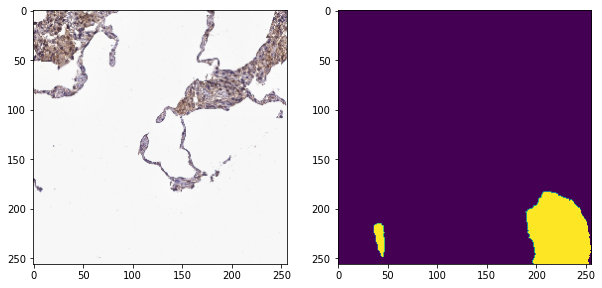

In [29]:
temp_img = train_data[54][0]
temp_mask = train_data[54][1]
# plt.imshow(temp_mask.detach().numpy())
# plt.imshow(temp_img.permute(1,2,0).detach().numpy())


img_trfm = (temp_img.permute(1,2,0)).detach().numpy()
mask_trfm = (temp_mask.permute(1,2,0)).detach().numpy()

plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
plt.imshow(img_trfm)


plt.subplot(1,2,2)
plt.imshow(mask_trfm)
print(np.unique(mask_trfm))
# temp_img.permute(1,2,0).detach().numpy() # 0.00784314 0.00392157

# Unet Model:

In [30]:
def init_model():
    model =  smp.Unet(
                 encoder_name='efficientnet-b0',
                 encoder_weights='imagenet',
                 in_channels=3,
                 classes=1)
    return model

# Model check:

In [31]:
train_on_gpu = torch.cuda.is_available()
model = init_model() #UNet(n_channels=CONFIG["in_channels"], n_classes=CONFIG["num_classes"])
if train_on_gpu:
    model.cuda()

model(temp_img.unsqueeze(0).float().cuda()).shape

torch.Size([1, 1, 256, 256])

# DataLoader

In [32]:
# REMARK shuffle = False [result might change with shuffle =True]
train_loader = torch.utils.data.DataLoader(
               dataset=train_data,
               batch_size=16,#CONFIG["BATCH_SIZE"],
               shuffle=False,
               num_workers=2)

test_loader = torch.utils.data.DataLoader(
              dataset=test_data,
              batch_size=CONFIG["BATCH_SIZE"],
              shuffle=False,
              num_workers=2)

torch.uint8


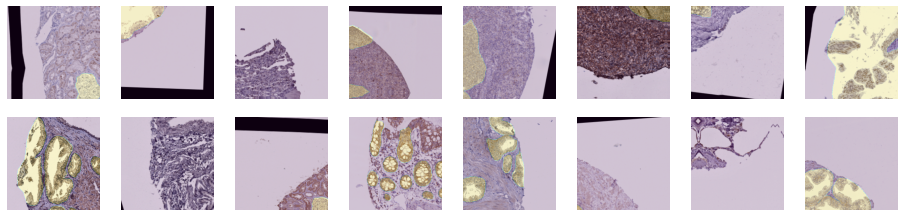

In [33]:
# ds = HuBMAPDataset(tfms=albu_aug())
# dl = torch.utils.data.DataLoader(ds,batch_size=64,shuffle=False,num_workers=NUM_WORKERS)
it = iter(train_loader)
imgs,masks = next(it)
print(masks.dtype)
plt.figure(figsize=(16,16))
for i,(img,mask) in enumerate(zip(imgs,masks)):
    img = ((img.permute(1,2,0))).numpy().astype(np.uint8)  # H , W , C
    plt.subplot(8,8,i+1)
    plt.imshow(img,vmin=0,vmax=255)
    plt.imshow(mask.squeeze().numpy(), alpha=0.2)
    plt.axis('off')
    plt.subplots_adjust(wspace=None, hspace=None)
    
# del ds,dl,imgs,masks

In [34]:
def get_scheduler(optimizer):
    num_steps = 12
      
    if CONFIG["scheduler"] == 'CosineAnnealingLR':
        scheduler = lr_scheduler.CosineAnnealingLR(optimizer,T_max=CONFIG['T_max'], 
                                                   eta_min=CONFIG['min_lr'])
        
    elif CONFIG["scheduler"] == 'ReduceLROnPlateau':
        scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=7, threshold=0.0001, min_lr=1e-6)
    elif CONFIG["scheduler"] == 'ExponentialLR':
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.85)
    elif CONFIG['scheduler'] == 'CosineAnnealingWarmRestarts':
        scheduler = lr_scheduler.CosineAnnealingWarmRestarts(optimizer,T_0=CONFIG['T_0'], 
                                                             eta_min=CONFIG['min_lr'])
        
    return scheduler

# Loss, Optimizer & Metric:

In [35]:
#PyTorch
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice

loss_fn = DiceLoss() #Dice()
JaccardLoss = smp.losses.JaccardLoss(mode='multilabel')
DiceLoss    = smp.losses.DiceLoss(mode='multilabel')
BCELoss     = smp.losses.SoftBCEWithLogitsLoss()
LovaszLoss  = smp.losses.LovaszLoss(mode='multilabel', per_image=False)
TverskyLoss = smp.losses.TverskyLoss(mode='multilabel', log_loss=False)

optimizer = optim.Adam(model.parameters(), lr=CONFIG["LEARNING_RATE"],weight_decay=1e-5)

In [36]:
class DiceCoef(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, y_pred, y_true, smooth=1.):
        y_true = y_true.view(-1)
        y_pred = y_pred.view(-1)
        
        #Round off y_pred
        y_pred = torch.round((y_pred - y_pred.min()) / (y_pred.max() - y_pred.min()))
        
        intersection = (y_true * y_pred).sum()
        dice = (2.0*intersection + smooth)/(y_true.sum() + y_pred.sum() + smooth)
        
        return dice

def dice_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    den = y_true.sum(dim=dim) + y_pred.sum(dim=dim)
    dice = ((2*inter+epsilon)/(den+epsilon)).mean(dim=(1,0))
    return dice

def iou_coef(y_true, y_pred, thr=0.5, dim=(2,3), epsilon=0.001):
    y_true = y_true.to(torch.float32)
    y_pred = (y_pred>thr).to(torch.float32)
    inter = (y_true*y_pred).sum(dim=dim)
    union = (y_true + y_pred - y_true*y_pred).sum(dim=dim)
    iou = ((inter+epsilon)/(union+epsilon)).mean(dim=(1,0))
    return iou

dice_coe = DiceCoef()

# model save class:

In [37]:
model_path = "./model_weights_effunet_no_sch_tiled_bin_class"
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
def save_model(model, optimizer, criterion, epoch):
    """
    Function to save the trained model to disk.
    """
    print(f"\n Saving model at {epoch}th epoch")
    fname = f'{model_path}/{CONFIG["model_name"]}-{CONFIG["LEARNING_RATE"]}-{CONFIG["AUG"]}-{epoch}-{CONFIG["BATCH_SIZE"]}.pth'
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': criterion,
                }, fname )
    return fname

## Train & Validation Function:

In [38]:
# https://www.kaggle.com/code/debarshichanda/pytorch-w-b-birdclef-22-starter#Training-Function
def train_fn(loader, model, optimizer, loss_fn,epoch):
    bar = tqdm(enumerate(loader), total=len(loader))
    
    
    running_loss = 0.0
    dataset_size = 0
    
    for batch_idx, (data, targets) in bar:
        data = data.float().to(device=CONFIG["DEVICE"])
        targets = targets.float().to(device=CONFIG["DEVICE"])

        # forward
        predictions = model(data)

        loss = loss_fn(predictions, targets)

        
        optimizer.zero_grad()
        # backward
        loss.backward()
        # Update Weights
        optimizer.step()
        
#         if scheduler is not None:
#             scheduler.step()
            
        # Calculate Loss
        running_loss += loss.item()
        
        epoch_loss = running_loss / len(loader)
#         running_loss += (loss.item() * BATCH_SIZE)
#         dataset_size += BATCH_SIZE
        
#         epoch_loss = running_loss / dataset_size
        # update tqdm loop
        bar.set_postfix(Epoch=epoch,loss=epoch_loss)
    
        
    gc.collect()
    
    return epoch_loss

In [39]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch, loss_fn):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
#     criterion = losses[CFG.loss]
    
    val_scores = []
    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, (images, masks) in pbar:
        images  = images.to(CONFIG["DEVICE"], dtype=torch.float)
        masks   = masks.to(CONFIG["DEVICE"], dtype=torch.float)
        
        
        y_pred  = model(images)
        loss    = loss_fn(y_pred, masks)
        
        running_loss += (loss.item() * CONFIG["BATCH_SIZE"])
        dataset_size += CONFIG["BATCH_SIZE"]
        
        epoch_loss = running_loss / dataset_size
        
        y_pred = nn.Sigmoid()(y_pred)
        val_dice = dice_coef(masks, y_pred).cpu().detach().numpy()
        val_jaccard = iou_coef(masks, y_pred).cpu().detach().numpy()
        val_scores.append([val_dice, val_jaccard])
        
        mem = torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0
        current_lr = optimizer.param_groups[0]['lr']
        pbar.set_postfix(valid_loss=f'{epoch_loss:0.4f}',
                        lr=f'{current_lr:0.5f}',
                        gpu_memory=f'{mem:0.2f} GB')
    val_scores  = np.mean(val_scores, axis=0)
    torch.cuda.empty_cache()
    gc.collect()
    
    return epoch_loss, val_scores

# Train loop:

===================== Epoch: [1/100] =====================


100%|██████████| 79/79 [03:01<00:00,  2.29s/it, gpu_memory=3.34 GB, lr=0.00010, valid_loss=0.3423]



 Saving model at 1th epoch

 Final Train Loss: 0.5725  |  Final Val Loss: 0.3423
Valid Dice: 0.2740 | Valid Jaccard: 0.2118
val dice increased: -inf ---> 0.2740319073200226
val jaccard increased: -inf ---> 0.21177852153778076
===================== Epoch: [2/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.86it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1487]



 Saving model at 2th epoch

 Final Train Loss: 0.1599  |  Final Val Loss: 0.1487
Valid Dice: 0.4604 | Valid Jaccard: 0.4063
val dice increased: 0.2740319073200226 ---> 0.46039271354675293
val jaccard increased: 0.21177852153778076 ---> 0.40630924701690674
===================== Epoch: [3/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.89it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1121]



 Saving model at 3th epoch

 Final Train Loss: 0.1287  |  Final Val Loss: 0.1121
Valid Dice: 0.5449 | Valid Jaccard: 0.4904
val dice increased: 0.46039271354675293 ---> 0.5448552370071411
val jaccard increased: 0.40630924701690674 ---> 0.49039173126220703
===================== Epoch: [4/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.80it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1037]



 Saving model at 4th epoch

 Final Train Loss: 0.1132  |  Final Val Loss: 0.1037
Valid Dice: 0.6238 | Valid Jaccard: 0.5693
val dice increased: 0.5448552370071411 ---> 0.6238093972206116
val jaccard increased: 0.49039173126220703 ---> 0.5693173408508301
===================== Epoch: [5/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.93it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1021]



 Saving model at 5th epoch

 Final Train Loss: 0.1040  |  Final Val Loss: 0.1021
Valid Dice: 0.6718 | Valid Jaccard: 0.6192
val dice increased: 0.6238093972206116 ---> 0.6717789769172668
val jaccard increased: 0.5693173408508301 ---> 0.6192241907119751
===================== Epoch: [6/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.79it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0944]



 Saving model at 6th epoch

 Final Train Loss: 0.0995  |  Final Val Loss: 0.0944
Valid Dice: 0.6656 | Valid Jaccard: 0.6120
===================== Epoch: [7/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.80it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0989]



 Saving model at 7th epoch

 Final Train Loss: 0.0931  |  Final Val Loss: 0.0989
Valid Dice: 0.7026 | Valid Jaccard: 0.6528
val dice increased: 0.6717789769172668 ---> 0.702570915222168
val jaccard increased: 0.6192241907119751 ---> 0.6528330445289612
===================== Epoch: [8/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.83it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1023]



 Saving model at 8th epoch

 Final Train Loss: 0.0860  |  Final Val Loss: 0.1023
Valid Dice: 0.7172 | Valid Jaccard: 0.6675
val dice increased: 0.702570915222168 ---> 0.7171646356582642
val jaccard increased: 0.6528330445289612 ---> 0.6674961447715759
===================== Epoch: [9/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.82it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0999]



 Saving model at 9th epoch

 Final Train Loss: 0.0822  |  Final Val Loss: 0.0999
Valid Dice: 0.7237 | Valid Jaccard: 0.6771
val dice increased: 0.7171646356582642 ---> 0.723724901676178
val jaccard increased: 0.6674961447715759 ---> 0.6770637631416321
===================== Epoch: [10/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.97it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0953]



 Saving model at 10th epoch

 Final Train Loss: 0.0774  |  Final Val Loss: 0.0953
Valid Dice: 0.7311 | Valid Jaccard: 0.6841
val dice increased: 0.723724901676178 ---> 0.7311299443244934
val jaccard increased: 0.6770637631416321 ---> 0.6841458678245544
===================== Epoch: [11/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.92it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0994]



 Saving model at 11th epoch

 Final Train Loss: 0.0757  |  Final Val Loss: 0.0994
Valid Dice: 0.7293 | Valid Jaccard: 0.6821
===================== Epoch: [12/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.91it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0945]



 Saving model at 12th epoch

 Final Train Loss: 0.0747  |  Final Val Loss: 0.0945
Valid Dice: 0.7239 | Valid Jaccard: 0.6764
===================== Epoch: [13/100] =====================


100%|██████████| 79/79 [00:09<00:00,  8.76it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0854]



 Saving model at 13th epoch

 Final Train Loss: 0.0699  |  Final Val Loss: 0.0854
Valid Dice: 0.7215 | Valid Jaccard: 0.6754
===================== Epoch: [14/100] =====================


100%|██████████| 79/79 [00:09<00:00,  8.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0962]



 Saving model at 14th epoch

 Final Train Loss: 0.0702  |  Final Val Loss: 0.0962
Valid Dice: 0.7240 | Valid Jaccard: 0.6781
===================== Epoch: [15/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0950]



 Saving model at 15th epoch

 Final Train Loss: 0.0651  |  Final Val Loss: 0.0950
Valid Dice: 0.6812 | Valid Jaccard: 0.6332
===================== Epoch: [16/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1127]



 Saving model at 16th epoch

 Final Train Loss: 0.0667  |  Final Val Loss: 0.1127
Valid Dice: 0.7130 | Valid Jaccard: 0.6677
===================== Epoch: [17/100] =====================


100%|██████████| 79/79 [00:10<00:00,  7.86it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0823]



 Saving model at 17th epoch

 Final Train Loss: 0.0631  |  Final Val Loss: 0.0823
Valid Dice: 0.7389 | Valid Jaccard: 0.6917
val dice increased: 0.7311299443244934 ---> 0.7388610243797302
val jaccard increased: 0.6841458678245544 ---> 0.6917158365249634
===================== Epoch: [18/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0863]



 Saving model at 18th epoch

 Final Train Loss: 0.0595  |  Final Val Loss: 0.0863
Valid Dice: 0.7394 | Valid Jaccard: 0.6929
val dice increased: 0.7388610243797302 ---> 0.7393980622291565
val jaccard increased: 0.6917158365249634 ---> 0.6928930878639221
===================== Epoch: [19/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0847]



 Saving model at 19th epoch

 Final Train Loss: 0.0612  |  Final Val Loss: 0.0847
Valid Dice: 0.7430 | Valid Jaccard: 0.6986
val dice increased: 0.7393980622291565 ---> 0.7430151700973511
val jaccard increased: 0.6928930878639221 ---> 0.6985777616500854
===================== Epoch: [20/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0945]



 Saving model at 20th epoch

 Final Train Loss: 0.0575  |  Final Val Loss: 0.0945
Valid Dice: 0.7496 | Valid Jaccard: 0.7042
val dice increased: 0.7430151700973511 ---> 0.7496224641799927
val jaccard increased: 0.6985777616500854 ---> 0.704227089881897
===================== Epoch: [21/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.12it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0782]



 Saving model at 21th epoch

 Final Train Loss: 0.0610  |  Final Val Loss: 0.0782
Valid Dice: 0.7461 | Valid Jaccard: 0.7012
===================== Epoch: [22/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.83it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0836]



 Saving model at 22th epoch

 Final Train Loss: 0.0561  |  Final Val Loss: 0.0836
Valid Dice: 0.7406 | Valid Jaccard: 0.6958
===================== Epoch: [23/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0817]



 Saving model at 23th epoch

 Final Train Loss: 0.0544  |  Final Val Loss: 0.0817
Valid Dice: 0.7450 | Valid Jaccard: 0.7002
===================== Epoch: [24/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0807]



 Saving model at 24th epoch

 Final Train Loss: 0.0544  |  Final Val Loss: 0.0807
Valid Dice: 0.7540 | Valid Jaccard: 0.7082
val dice increased: 0.7496224641799927 ---> 0.7539520263671875
val jaccard increased: 0.704227089881897 ---> 0.7081528902053833
===================== Epoch: [25/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.00it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0869]



 Saving model at 25th epoch

 Final Train Loss: 0.0537  |  Final Val Loss: 0.0869
Valid Dice: 0.7437 | Valid Jaccard: 0.6990
===================== Epoch: [26/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.92it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0959]



 Saving model at 26th epoch

 Final Train Loss: 0.0509  |  Final Val Loss: 0.0959
Valid Dice: 0.7505 | Valid Jaccard: 0.7050
===================== Epoch: [27/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0885]



 Saving model at 27th epoch

 Final Train Loss: 0.0507  |  Final Val Loss: 0.0885
Valid Dice: 0.7390 | Valid Jaccard: 0.6948
===================== Epoch: [28/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.03it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0856]



 Saving model at 28th epoch

 Final Train Loss: 0.0533  |  Final Val Loss: 0.0856
Valid Dice: 0.7596 | Valid Jaccard: 0.7146
val dice increased: 0.7539520263671875 ---> 0.7596228122711182
val jaccard increased: 0.7081528902053833 ---> 0.7146256566047668
===================== Epoch: [29/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.04it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0873]



 Saving model at 29th epoch

 Final Train Loss: 0.0553  |  Final Val Loss: 0.0873
Valid Dice: 0.7491 | Valid Jaccard: 0.7049
===================== Epoch: [30/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0908]



 Saving model at 30th epoch

 Final Train Loss: 0.0535  |  Final Val Loss: 0.0908
Valid Dice: 0.7605 | Valid Jaccard: 0.7179
val dice increased: 0.7596228122711182 ---> 0.7605427503585815
val jaccard increased: 0.7146256566047668 ---> 0.717865526676178
===================== Epoch: [31/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0848]



 Saving model at 31th epoch

 Final Train Loss: 0.0480  |  Final Val Loss: 0.0848
Valid Dice: 0.7558 | Valid Jaccard: 0.7121
===================== Epoch: [32/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.06it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0836]



 Saving model at 32th epoch

 Final Train Loss: 0.0492  |  Final Val Loss: 0.0836
Valid Dice: 0.7668 | Valid Jaccard: 0.7247
val dice increased: 0.7605427503585815 ---> 0.7668046355247498
val jaccard increased: 0.717865526676178 ---> 0.7246951460838318
===================== Epoch: [33/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.06it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0814]



 Saving model at 33th epoch

 Final Train Loss: 0.0490  |  Final Val Loss: 0.0814
Valid Dice: 0.7677 | Valid Jaccard: 0.7245
val dice increased: 0.7668046355247498 ---> 0.767668604850769
===================== Epoch: [34/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0815]



 Saving model at 34th epoch

 Final Train Loss: 0.0478  |  Final Val Loss: 0.0815
Valid Dice: 0.7630 | Valid Jaccard: 0.7203
===================== Epoch: [35/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.02it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0935]



 Saving model at 35th epoch

 Final Train Loss: 0.0502  |  Final Val Loss: 0.0935
Valid Dice: 0.7444 | Valid Jaccard: 0.7002
===================== Epoch: [36/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0953]



 Saving model at 36th epoch

 Final Train Loss: 0.0487  |  Final Val Loss: 0.0953
Valid Dice: 0.7615 | Valid Jaccard: 0.7187
===================== Epoch: [37/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0942]



 Saving model at 37th epoch

 Final Train Loss: 0.0453  |  Final Val Loss: 0.0942
Valid Dice: 0.7674 | Valid Jaccard: 0.7240
===================== Epoch: [38/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.03it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0883]



 Saving model at 38th epoch

 Final Train Loss: 0.0438  |  Final Val Loss: 0.0883
Valid Dice: 0.7553 | Valid Jaccard: 0.7119
===================== Epoch: [39/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0836]



 Saving model at 39th epoch

 Final Train Loss: 0.0447  |  Final Val Loss: 0.0836
Valid Dice: 0.7597 | Valid Jaccard: 0.7153
===================== Epoch: [40/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0930]



 Saving model at 40th epoch

 Final Train Loss: 0.0434  |  Final Val Loss: 0.0930
Valid Dice: 0.7650 | Valid Jaccard: 0.7208
===================== Epoch: [41/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0944]



 Saving model at 41th epoch

 Final Train Loss: 0.0435  |  Final Val Loss: 0.0944
Valid Dice: 0.7718 | Valid Jaccard: 0.7295
val dice increased: 0.767668604850769 ---> 0.7718429565429688
val jaccard increased: 0.7246951460838318 ---> 0.7295495867729187
===================== Epoch: [42/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0898]



 Saving model at 42th epoch

 Final Train Loss: 0.0432  |  Final Val Loss: 0.0898
Valid Dice: 0.7673 | Valid Jaccard: 0.7249
===================== Epoch: [43/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0862]



 Saving model at 43th epoch

 Final Train Loss: 0.0432  |  Final Val Loss: 0.0862
Valid Dice: 0.7605 | Valid Jaccard: 0.7189
===================== Epoch: [44/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.11it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0857]



 Saving model at 44th epoch

 Final Train Loss: 0.0452  |  Final Val Loss: 0.0857
Valid Dice: 0.7618 | Valid Jaccard: 0.7198
===================== Epoch: [45/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.02it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0853]



 Saving model at 45th epoch

 Final Train Loss: 0.0423  |  Final Val Loss: 0.0853
Valid Dice: 0.7679 | Valid Jaccard: 0.7257
===================== Epoch: [46/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.04it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0830]



 Saving model at 46th epoch

 Final Train Loss: 0.0428  |  Final Val Loss: 0.0830
Valid Dice: 0.7712 | Valid Jaccard: 0.7280
===================== Epoch: [47/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.03it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0897]



 Saving model at 47th epoch

 Final Train Loss: 0.0416  |  Final Val Loss: 0.0897
Valid Dice: 0.7705 | Valid Jaccard: 0.7285
===================== Epoch: [48/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.11it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0866]



 Saving model at 48th epoch

 Final Train Loss: 0.0408  |  Final Val Loss: 0.0866
Valid Dice: 0.7685 | Valid Jaccard: 0.7267
===================== Epoch: [49/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0854]



 Saving model at 49th epoch

 Final Train Loss: 0.0402  |  Final Val Loss: 0.0854
Valid Dice: 0.7648 | Valid Jaccard: 0.7239
===================== Epoch: [50/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0867]



 Saving model at 50th epoch

 Final Train Loss: 0.0406  |  Final Val Loss: 0.0867
Valid Dice: 0.7545 | Valid Jaccard: 0.7117
===================== Epoch: [51/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0929]



 Saving model at 51th epoch

 Final Train Loss: 0.0416  |  Final Val Loss: 0.0929
Valid Dice: 0.7653 | Valid Jaccard: 0.7242
===================== Epoch: [52/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0895]



 Saving model at 52th epoch

 Final Train Loss: 0.0415  |  Final Val Loss: 0.0895
Valid Dice: 0.7716 | Valid Jaccard: 0.7302
val jaccard increased: 0.7295495867729187 ---> 0.7302236557006836
===================== Epoch: [53/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0972]



 Saving model at 53th epoch

 Final Train Loss: 0.0386  |  Final Val Loss: 0.0972
Valid Dice: 0.7700 | Valid Jaccard: 0.7287
===================== Epoch: [54/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0906]



 Saving model at 54th epoch

 Final Train Loss: 0.0456  |  Final Val Loss: 0.0906
Valid Dice: 0.7566 | Valid Jaccard: 0.7150
===================== Epoch: [55/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0844]



 Saving model at 55th epoch

 Final Train Loss: 0.0438  |  Final Val Loss: 0.0844
Valid Dice: 0.7532 | Valid Jaccard: 0.7109
===================== Epoch: [56/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0912]



 Saving model at 56th epoch

 Final Train Loss: 0.0426  |  Final Val Loss: 0.0912
Valid Dice: 0.7606 | Valid Jaccard: 0.7183
===================== Epoch: [57/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0929]



 Saving model at 57th epoch

 Final Train Loss: 0.0382  |  Final Val Loss: 0.0929
Valid Dice: 0.7686 | Valid Jaccard: 0.7282
===================== Epoch: [58/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0885]



 Saving model at 58th epoch

 Final Train Loss: 0.0372  |  Final Val Loss: 0.0885
Valid Dice: 0.7611 | Valid Jaccard: 0.7194
===================== Epoch: [59/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0970]



 Saving model at 59th epoch

 Final Train Loss: 0.0369  |  Final Val Loss: 0.0970
Valid Dice: 0.7637 | Valid Jaccard: 0.7217
===================== Epoch: [60/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0951]



 Saving model at 60th epoch

 Final Train Loss: 0.0361  |  Final Val Loss: 0.0951
Valid Dice: 0.7684 | Valid Jaccard: 0.7276
===================== Epoch: [61/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.96it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0902]



 Saving model at 61th epoch

 Final Train Loss: 0.0361  |  Final Val Loss: 0.0902
Valid Dice: 0.7627 | Valid Jaccard: 0.7200
===================== Epoch: [62/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0912]



 Saving model at 62th epoch

 Final Train Loss: 0.0358  |  Final Val Loss: 0.0912
Valid Dice: 0.7663 | Valid Jaccard: 0.7254
===================== Epoch: [63/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0903]



 Saving model at 63th epoch

 Final Train Loss: 0.0359  |  Final Val Loss: 0.0903
Valid Dice: 0.7599 | Valid Jaccard: 0.7174
===================== Epoch: [64/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0958]



 Saving model at 64th epoch

 Final Train Loss: 0.0348  |  Final Val Loss: 0.0958
Valid Dice: 0.7740 | Valid Jaccard: 0.7327
val dice increased: 0.7718429565429688 ---> 0.7740395069122314
val jaccard increased: 0.7302236557006836 ---> 0.7326973676681519
===================== Epoch: [65/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1039]



 Saving model at 65th epoch

 Final Train Loss: 0.0363  |  Final Val Loss: 0.1039
Valid Dice: 0.7743 | Valid Jaccard: 0.7337
val dice increased: 0.7740395069122314 ---> 0.77427738904953
val jaccard increased: 0.7326973676681519 ---> 0.7336561679840088
===================== Epoch: [66/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.88it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0838]



 Saving model at 66th epoch

 Final Train Loss: 0.0472  |  Final Val Loss: 0.0838
Valid Dice: 0.7759 | Valid Jaccard: 0.7334
val dice increased: 0.77427738904953 ---> 0.7759214043617249
===================== Epoch: [67/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0898]



 Saving model at 67th epoch

 Final Train Loss: 0.0368  |  Final Val Loss: 0.0898
Valid Dice: 0.7685 | Valid Jaccard: 0.7256
===================== Epoch: [68/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0843]



 Saving model at 68th epoch

 Final Train Loss: 0.0392  |  Final Val Loss: 0.0843
Valid Dice: 0.7675 | Valid Jaccard: 0.7256
===================== Epoch: [69/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0992]



 Saving model at 69th epoch

 Final Train Loss: 0.0362  |  Final Val Loss: 0.0992
Valid Dice: 0.7665 | Valid Jaccard: 0.7246
===================== Epoch: [70/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0880]



 Saving model at 70th epoch

 Final Train Loss: 0.0389  |  Final Val Loss: 0.0880
Valid Dice: 0.7689 | Valid Jaccard: 0.7283
===================== Epoch: [71/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0950]



 Saving model at 71th epoch

 Final Train Loss: 0.0351  |  Final Val Loss: 0.0950
Valid Dice: 0.7746 | Valid Jaccard: 0.7341
val jaccard increased: 0.7336561679840088 ---> 0.7340503931045532
===================== Epoch: [72/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0982]



 Saving model at 72th epoch

 Final Train Loss: 0.0344  |  Final Val Loss: 0.0982
Valid Dice: 0.7671 | Valid Jaccard: 0.7255
===================== Epoch: [73/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.06it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0887]



 Saving model at 73th epoch

 Final Train Loss: 0.0369  |  Final Val Loss: 0.0887
Valid Dice: 0.7650 | Valid Jaccard: 0.7223
===================== Epoch: [74/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0938]



 Saving model at 74th epoch

 Final Train Loss: 0.0373  |  Final Val Loss: 0.0938
Valid Dice: 0.7547 | Valid Jaccard: 0.7131
===================== Epoch: [75/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.11it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0935]



 Saving model at 75th epoch

 Final Train Loss: 0.0368  |  Final Val Loss: 0.0935
Valid Dice: 0.7738 | Valid Jaccard: 0.7330
===================== Epoch: [76/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0955]



 Saving model at 76th epoch

 Final Train Loss: 0.0343  |  Final Val Loss: 0.0955
Valid Dice: 0.7708 | Valid Jaccard: 0.7307
===================== Epoch: [77/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0976]



 Saving model at 77th epoch

 Final Train Loss: 0.0340  |  Final Val Loss: 0.0976
Valid Dice: 0.7579 | Valid Jaccard: 0.7159
===================== Epoch: [78/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0951]



 Saving model at 78th epoch

 Final Train Loss: 0.0332  |  Final Val Loss: 0.0951
Valid Dice: 0.7639 | Valid Jaccard: 0.7230
===================== Epoch: [79/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.06it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1039]



 Saving model at 79th epoch

 Final Train Loss: 0.0336  |  Final Val Loss: 0.1039
Valid Dice: 0.7603 | Valid Jaccard: 0.7190
===================== Epoch: [80/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.09it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1009]



 Saving model at 80th epoch

 Final Train Loss: 0.0336  |  Final Val Loss: 0.1009
Valid Dice: 0.7621 | Valid Jaccard: 0.7198
===================== Epoch: [81/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1000]



 Saving model at 81th epoch

 Final Train Loss: 0.0330  |  Final Val Loss: 0.1000
Valid Dice: 0.7707 | Valid Jaccard: 0.7296
===================== Epoch: [82/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.03it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1052]



 Saving model at 82th epoch

 Final Train Loss: 0.0324  |  Final Val Loss: 0.1052
Valid Dice: 0.7670 | Valid Jaccard: 0.7253
===================== Epoch: [83/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.03it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0952]



 Saving model at 83th epoch

 Final Train Loss: 0.0325  |  Final Val Loss: 0.0952
Valid Dice: 0.7723 | Valid Jaccard: 0.7303
===================== Epoch: [84/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0938]



 Saving model at 84th epoch

 Final Train Loss: 0.0384  |  Final Val Loss: 0.0938
Valid Dice: 0.7631 | Valid Jaccard: 0.7223
===================== Epoch: [85/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0993]



 Saving model at 85th epoch

 Final Train Loss: 0.0354  |  Final Val Loss: 0.0993
Valid Dice: 0.7724 | Valid Jaccard: 0.7302
===================== Epoch: [86/100] =====================


100%|██████████| 79/79 [00:09<00:00,  8.29it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0944]



 Saving model at 86th epoch

 Final Train Loss: 0.0328  |  Final Val Loss: 0.0944
Valid Dice: 0.7680 | Valid Jaccard: 0.7267
===================== Epoch: [87/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.79it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1021]



 Saving model at 87th epoch

 Final Train Loss: 0.0326  |  Final Val Loss: 0.1021
Valid Dice: 0.7498 | Valid Jaccard: 0.7092
===================== Epoch: [88/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1025]



 Saving model at 88th epoch

 Final Train Loss: 0.0322  |  Final Val Loss: 0.1025
Valid Dice: 0.7684 | Valid Jaccard: 0.7286
===================== Epoch: [89/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.12it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0986]



 Saving model at 89th epoch

 Final Train Loss: 0.0411  |  Final Val Loss: 0.0986
Valid Dice: 0.7618 | Valid Jaccard: 0.7219
===================== Epoch: [90/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.11it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0956]



 Saving model at 90th epoch

 Final Train Loss: 0.0358  |  Final Val Loss: 0.0956
Valid Dice: 0.7413 | Valid Jaccard: 0.6971
===================== Epoch: [91/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0974]



 Saving model at 91th epoch

 Final Train Loss: 0.0335  |  Final Val Loss: 0.0974
Valid Dice: 0.7493 | Valid Jaccard: 0.7076
===================== Epoch: [92/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0977]



 Saving model at 92th epoch

 Final Train Loss: 0.0355  |  Final Val Loss: 0.0977
Valid Dice: 0.7683 | Valid Jaccard: 0.7269
===================== Epoch: [93/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.08it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0910]



 Saving model at 93th epoch

 Final Train Loss: 0.0336  |  Final Val Loss: 0.0910
Valid Dice: 0.7636 | Valid Jaccard: 0.7213
===================== Epoch: [94/100] =====================


100%|██████████| 79/79 [00:09<00:00,  8.46it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0952]



 Saving model at 94th epoch

 Final Train Loss: 0.0312  |  Final Val Loss: 0.0952
Valid Dice: 0.7641 | Valid Jaccard: 0.7224
===================== Epoch: [95/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.07it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0962]



 Saving model at 95th epoch

 Final Train Loss: 0.0308  |  Final Val Loss: 0.0962
Valid Dice: 0.7562 | Valid Jaccard: 0.7137
===================== Epoch: [96/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.10it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.1007]



 Saving model at 96th epoch

 Final Train Loss: 0.0299  |  Final Val Loss: 0.1007
Valid Dice: 0.7539 | Valid Jaccard: 0.7136
===================== Epoch: [97/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.11it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0986]



 Saving model at 97th epoch

 Final Train Loss: 0.0307  |  Final Val Loss: 0.0986
Valid Dice: 0.7596 | Valid Jaccard: 0.7181
===================== Epoch: [98/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.06it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0999]



 Saving model at 98th epoch

 Final Train Loss: 0.0386  |  Final Val Loss: 0.0999
Valid Dice: 0.7588 | Valid Jaccard: 0.7171
===================== Epoch: [99/100] =====================


100%|██████████| 79/79 [00:08<00:00,  8.88it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0990]



 Saving model at 99th epoch

 Final Train Loss: 0.0414  |  Final Val Loss: 0.0990
Valid Dice: 0.7542 | Valid Jaccard: 0.7132
===================== Epoch: [100/100] =====================


100%|██████████| 79/79 [00:08<00:00,  9.05it/s, gpu_memory=3.37 GB, lr=0.00010, valid_loss=0.0961]



 Saving model at 100th epoch

 Final Train Loss: 0.0329  |  Final Val Loss: 0.0961
Valid Dice: 0.7533 | Valid Jaccard: 0.7122

 ====================== [Training Summary] ====================== 

Training complete in 1h 46m 46s
avg time per [train + val] epoch 0h 1m 4s
Best: ~~~~~~ dice: 0.7759  || jaccard 0.7341 || val_loss 0.0782 || train_loss 0.0299 ~~~~~~
Saved training summary...




,epoch,Train_Loss,Valid_Loss,Valid_jaccard,Valid_dice,model_file
0,1,0.572457,0.342285,0.211779,0.274032,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-1-8.pth
1,2,0.159940,0.148667,0.406309,0.460393,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-2-8.pth
2,3,0.128688,0.112099,0.490392,0.544855,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-3-8.pth
3,4,0.113170,0.103722,0.569317,0.623809,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-4-8.pth
4,5,0.103957,0.102096,0.619224,0.671779,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-5-8.pth
...,...,...,...,...,...,...
95,96,0.029933,0.100651,0.713582,0.753950,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-96-8.pth
96,97,0.030691,0.098594,0.718087,0.759593,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-97-8.pth
97,98,0.038603,0.099853,0.717138,0.758794,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-98-8.pth
98,99,0.041412,0.098968,0.713176,0.754186,./model_weights_effunet_no_sch_tiled_bin_class/Vanilla_Unet-0.0001-No-99-8.pth


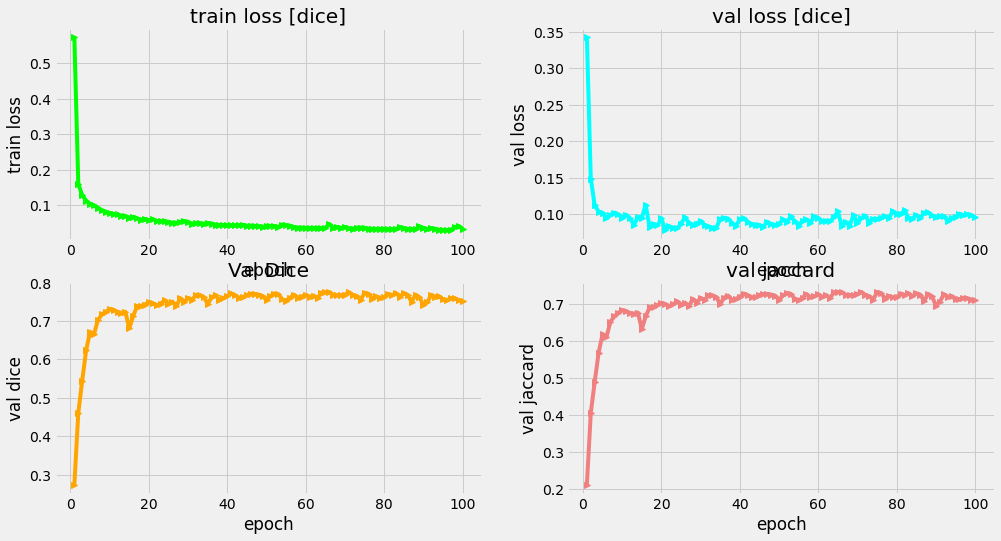

In [40]:
history = defaultdict(list)
best_val_dice = -float('inf')
best_val_jaccard = -float('inf')
start = time.time()

loss_fn = BCELoss

for epoch in range(CONFIG["NUM_EPOCHS"]):
    
    print(f'{sr_}===================== Epoch: [{epoch+1}/{CONFIG["NUM_EPOCHS"]}] =====================')

    # train and validation loop
    train_loss = train_fn(train_loader, model, optimizer, loss_fn, epoch+1)
    val_loss, val_scores = valid_one_epoch(model, test_loader,CONFIG["DEVICE"], epoch+1, loss_fn)
    val_dice, val_jaccard = val_scores
    
    
    # save model
    model_file = save_model(model, optimizer, BCELoss, epoch+1)
    
    
    # weight and baise Log the metrics
    wandb.log({"Train Loss": train_loss})
    wandb.log({"Valid Loss": val_loss})
    wandb.log({"Valid dice": val_dice})
    wandb.log({"Valid jaccard": val_jaccard})

    # logging
    history["epoch"].append(epoch+1)
    history['Train_Loss'].append(train_loss)
    history['Valid_Loss'].append(val_loss)
    history['Valid_jaccard'].append(val_jaccard)
    history['Valid_dice'].append(val_dice)
    history["model_file"].append(model_file)

    
    # print loss and scores
    print(f"\n Final Train Loss: {train_loss:0.4f}  |  Final Val Loss: {val_loss:0.4f}") 
    
    print(f'Valid Dice: {val_dice:0.4f} | Valid Jaccard: {val_jaccard:0.4f}')
    
    
    # print best val score
    if best_val_dice < val_dice:
        print(f"{b_}val dice increased: {best_val_dice} ---> {val_dice}")
        best_val_dice = val_dice
    
    if best_val_jaccard < val_jaccard:
        print(f"{b_}val jaccard increased: {best_val_jaccard} ---> {val_jaccard}")
        best_val_jaccard = val_jaccard
        
        
        
# print time
end = time.time()
time_elapsed = end - start
avg_time_per_epoch = time_elapsed/CONFIG["NUM_EPOCHS"] 
summary_df = pd.DataFrame.from_dict(history)

print(f'\n ====================== [Training Summary] ====================== \n')
print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
    time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))

print('avg time per [train + val] epoch {:.0f}h {:.0f}m {:.0f}s'.format(
    avg_time_per_epoch // 3600, (avg_time_per_epoch % 3600) // 60, (avg_time_per_epoch % 3600) % 60))

print("Best: ~~~~~~ dice: {:.4f}  || jaccard {:.4f} || val_loss {:.4f} || train_loss {:.4f} ~~~~~~".format(
    best_val_dice, best_val_jaccard, min(history['Valid_Loss']), min(history['Train_Loss'])))


summary_df.to_csv('training_summary.csv')
print("Saved training summary...")

print(f'\n =============================================================== \n')

display(summary_df)

plt.style.use('fivethirtyeight')
# plotting training and validation loss
plt.figure(figsize=(15,8))

fig1 = plt.subplot(2,2,1)
fig1.plot(history['epoch'], history['Train_Loss'], color='lime', marker='>')
fig1.set_title("train loss [dice]")
fig1.set(xlabel='epoch', ylabel='train loss')

fig2 = plt.subplot(2,2,2)
fig2.plot(history['epoch'], history['Valid_Loss'], color='cyan',  marker='>')
fig2.set_title("val loss [dice]")
fig2.set(xlabel='epoch', ylabel='val loss')

fig3 = plt.subplot(2,2,3)
fig3.plot(history['epoch'], history['Valid_dice'], color='orange',  marker='>')
fig3.set_title("Val Dice")
fig3.set(xlabel='epoch', ylabel='val dice')

fig4 = plt.subplot(2,2,4)
fig4.plot(history['epoch'], history['Valid_jaccard'], color='lightcoral',  marker='>')
fig4.set_title("val jaccard")
fig4.set(xlabel='epoch', ylabel='val jaccard')

plt.show();

# Inference:

In [41]:
# import numpy as np
# from PIL import Image

# def tile_image(p_img, folder, size: int = 768) -> list:
#     w = h = size
#     im = np.array(Image.open(p_img))
#     # https://stackoverflow.com/a/47581978/4521646
#     tiles = [im[i:(i + h), j:(j + w), ...] for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
#     idxs = [(i, (i + h), j, (j + w)) for i in range(0, im.shape[0], h) for j in range(0, im.shape[1], w)]
#     name, _ = os.path.splitext(os.path.basename(p_img))
#     files = []
#     for k, tile in enumerate(tiles):
#         if tile.shape[:2] != (h, w):
#             tile_ = tile
#             tile = np.zeros_like(tiles[0])
#             tile[:tile_.shape[0], :tile_.shape[1], ...] = tile_
#         p_img = os.path.join(folder, f"{name}_{k:02}.png")
#         Image.fromarray(tile).save(p_img)
#         files.append(p_img)
#     return files, idxs


In [42]:
# !mkdir -p /kaggle/temp/images

In [43]:
# !mkdir -p frozen_packages
# !cp ../input/starter-flash-semantic-segmentation/frozen_packages/* frozen_packages/
# !cp ../input/ftus-segm-eda-viewer/frozen_packages/* frozen_packages/
# !pip install -q 'kaggle-image-segmentation' --no-index --find-links frozen_packages/

In [44]:
# from scipy.ndimage import binary_opening
# from skimage.morphology import disk
# from kaggle_imsegm.mask import rle_encode


# DATASET_FOLDER = "/kaggle/input/hubmap-organ-segmentation"
# df_test = pd.read_csv("../input/hubmap-organ-segmentation/test.csv")
# TILE_SIZE = 1024

# preds = []
# for _, row in df_test.iterrows():
# #     print(row["pixel_size"])
#     scale = row["pixel_size"] / 0.4
#     test_img = os.path.join(DATASET_FOLDER, "test_images", f"{row['id']}.tiff")
#     im = plt.imread(test_img)
    
#     # perform scaling on level tiles as the input is scaled to the CNN input size anyway
    
#     tiles_img, idxs = tile_image(test_img, "/kaggle/temp/images", size=int(TILE_SIZE / scale))
# #     print(idxs)
#     pred_list = []
#     for img_file in tiles_img:
#         img_org = plt.imread(img_file)
        
#         transformed = test_transform(image=img_org)
#         img = transformed["image"]
#         img = img.reshape((1, *img.shape))
#         img = img.to(CONFIG["DEVICE"])
        
#         output = model(img)
#         output = nn.Sigmoid()(output)
#         msks = (output>0.5).to(torch.uint8).cpu().detach().numpy()
        
#         msks = msks.reshape((msks.shape[2], msks.shape[3]))
#         msks = cv2.resize(msks, (img_org.shape[0:2]), interpolation = cv2.INTER_AREA) #cv2.resize(msks,(*img_org.shape))
# #         print("msks--->", msks.shape)
        
#         pred_list.append(msks)
    
    
#     seg = np.zeros(im.shape[:2], dtype=np.uint8)
#     for tile, (i1, i2, j1, j2) in zip(pred_list, idxs):
#         i2 = min(i2, im.shape[0])
#         j2 = min(j2, im.shape[1])
# #         print('tile',np.array(tile, dtype=np.uint8)[:(i2 - i1), :(j2 - j1)].shape)
# #         print(seg[i1:i2, j1:j2].shape)
#         seg[i1:i2, j1:j2] = np.array(tile, dtype=np.uint8)[:(i2 - i1), :(j2 - j1)]
#     # seg = resize(seg * 255, img.shape[:2], order=0) / 255
#     seg = (seg >= 1).astype(np.uint8)  # binary mask
#     seg = binary_opening(seg, structure=disk(6)).astype(np.uint8)
    
    
#     rle = rle_encode(seg.T) if np.sum(seg) > 1 else {}
#     name, _ = os.path.splitext(os.path.basename(test_img))
#     preds.append({"id": row['id'], "rle": rle.get(1, "")})
    
# df_pred = pd.DataFrame(preds)
# display(df_pred[df_pred["rle"] != ""].head())

In [45]:
# df_ssub = pd.read_csv(os.path.join(DATASET_FOLDER, "sample_submission.csv"))
# del df_ssub['rle']
# df_pred = df_ssub.merge(df_pred, on='id')

# df_pred[['id', 'rle']].to_csv("submission.csv", index=False)

# !head submission.csv

In [46]:
# print(seg.shape)
# plt.imshow(seg)

# Model File Check:

In [47]:
!ls -la ./model_weights

ls: cannot access './model_weights': No such file or directory
